In [1]:
from google.colab import files
from google.colab import drive
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
drive.mount('/content/drive')

# path to zip file containing the dataset in Google Drive
!cp '/content/drive/My Drive/Database.zip' .

# extract the Database folder to the current directory
!unzip Database.zip -d ./

Mounted at /content/drive
Archive:  Database.zip
   creating: ./Database/
  inflating: ./__MACOSX/._Database   
  inflating: ./Database/Label.txt    
  inflating: ./__MACOSX/Database/._Label.txt  
  inflating: ./Database/.DS_Store    
  inflating: ./__MACOSX/Database/._.DS_Store  
   creating: ./Database/Image/
  inflating: ./__MACOSX/Database/._Image  
  inflating: ./Database/Image/6_P0_R30_00054.jpg  
  inflating: ./__MACOSX/Database/Image/._6_P0_R30_00054.jpg  
  inflating: ./Database/Image/6_P10_R20_00027.jpg  
  inflating: ./__MACOSX/Database/Image/._6_P10_R20_00027.jpg  
  inflating: ./Database/Image/6_P10_R20_00033.jpg  
  inflating: ./__MACOSX/Database/Image/._6_P10_R20_00033.jpg  
  inflating: ./Database/Image/6_P0_R30_00040.jpg  
  inflating: ./__MACOSX/Database/Image/._6_P0_R30_00040.jpg  
  inflating: ./Database/Image/6_P20_R50_00022.jpg  
  inflating: ./__MACOSX/Database/Image/._6_P20_R50_00022.jpg  
  inflating: ./Database/Image/6_P50_R60_00007.jpg  
  inflating: ./__MACO

In [3]:
label_path = '/content/Database/Label.txt'
image_folder = '/content/Database/Image'

# map the images with the label.txt
labels = pd.read_csv(label_path,
                     delimiter=' ',
                     header=None,
                     names=['Image', 'Pitch', 'Roll', 'Depth'])

print("First and last few rows of the labels:")
print(labels.head())
print(labels.tail())

First and last few rows of the labels:
               Image  Pitch  Roll     Depth
0  6_P0_R0_00001.jpg      0     0  0.611818
1  6_P0_R0_00002.jpg      0     0  0.693017
2  6_P0_R0_00003.jpg      0     0  0.457814
3  6_P0_R0_00004.jpg      0     0  0.105780
4  6_P0_R0_00005.jpg      0     0  0.296676
                    Image  Pitch  Roll     Depth
2011  6_P70_R70_00052.jpg     70    70  0.003353
2012  6_P70_R70_00053.jpg     70    70  0.958107
2013  6_P70_R70_00054.jpg     70    70  0.016327
2014  6_P70_R70_00055.jpg     70    70  0.000000
2015  6_P70_R70_00056.jpg     70    70  0.214759


In [4]:
images = {}

# Loop through image filenames in Label.txt and load them
for img_name in labels['Image']:
    img_path = os.path.join(image_folder, img_name)
    try:
        images[img_name] = Image.open(img_path)  # Open the image
    except FileNotFoundError:
        print(f"Warning: {img_name} not found in {image_folder}")

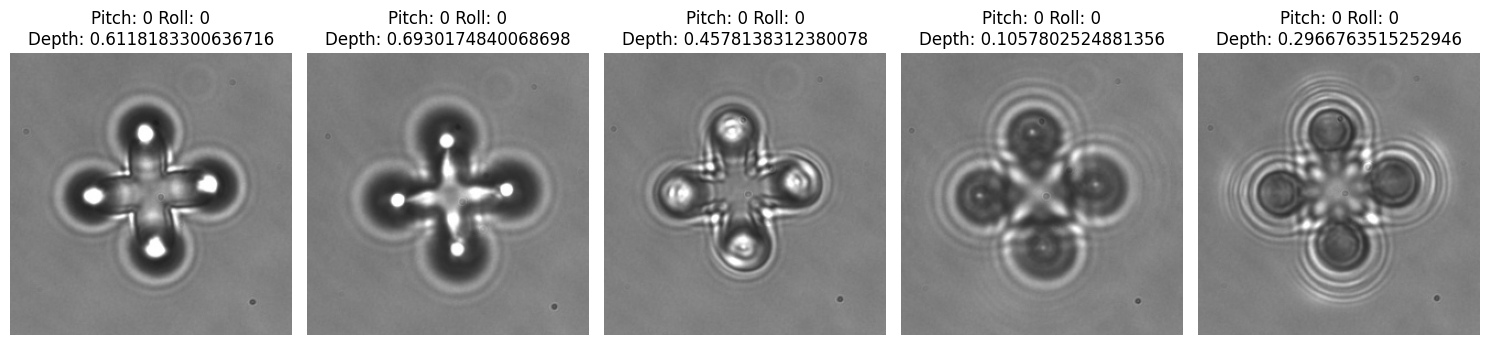

In [5]:
# Displaying few sample images with their labels
plt.figure(figsize=(15, 5))

for i in range(5):
    sample_image_path = labels['Image'].iloc[i]
    sample_pitch = labels['Pitch'].iloc[i]
    sample_roll = labels['Roll'].iloc[i]
    sample_depth = labels['Depth'].iloc[i]

    sample_image_path = os.path.join(image_folder, sample_image_path)

    image = Image.open(sample_image_path)

    plt.subplot(1, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Pitch: {sample_pitch} Roll: {sample_roll}\nDepth: {sample_depth}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [6]:
from sklearn.preprocessing import LabelEncoder

# combining the pitch and roll class into a single pose class
labels['Pose_Class'] = labels['Pitch'].astype(str) + '_' + labels['Roll'].astype(str)

#label encoding the combined class
label_encoder = LabelEncoder()
labels['Pose_Class_Label'] = label_encoder.fit_transform(labels['Pose_Class'])

In [7]:
print(labels.head())
print(labels.tail())

               Image  Pitch  Roll     Depth Pose_Class  Pose_Class_Label
0  6_P0_R0_00001.jpg      0     0  0.611818        0_0                 0
1  6_P0_R0_00002.jpg      0     0  0.693017        0_0                 0
2  6_P0_R0_00003.jpg      0     0  0.457814        0_0                 0
3  6_P0_R0_00004.jpg      0     0  0.105780        0_0                 0
4  6_P0_R0_00005.jpg      0     0  0.296676        0_0                 0
                    Image  Pitch  Roll     Depth Pose_Class  Pose_Class_Label
2011  6_P70_R70_00052.jpg     70    70  0.003353      70_70                35
2012  6_P70_R70_00053.jpg     70    70  0.958107      70_70                35
2013  6_P70_R70_00054.jpg     70    70  0.016327      70_70                35
2014  6_P70_R70_00055.jpg     70    70  0.000000      70_70                35
2015  6_P70_R70_00056.jpg     70    70  0.214759      70_70                35


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
import seaborn as sns

In [9]:
# creating a dataset of the pose classes

class PoseDataset(Dataset):
    def __init__(self, labels, transform=None):

        self.labels_df = labels  # Store the original dataframe
        self.transform = transform
        self.image_folder = image_folder # Assign image_folder to self

    def __len__(self):
        return len(self.labels_df)  # Use the original dataframe for length

    def __getitem__(self, idx):
        img_path = self.labels_df.iloc[idx]['Image']  # Use labels_df here
        img_path = os.path.join(self.image_folder, img_path)  # Construct full path using img_path, not img_name
        label = self.labels_df.iloc[idx]['Pose_Class_Label']  # Use labels_df here

        image = Image.open(img_path).convert("L")  # grayscale

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label


In [10]:
# SPLITTING the data into 60:20:20

train_df, test_df = train_test_split(labels,
                                     test_size=0.2,
                                     random_state=42,
                                     stratify=labels['Pose_Class_Label'])

train_df, val_df = train_test_split(train_df,
                                    test_size=0.25,
                                    random_state=42,
                                    stratify=train_df['Pose_Class_Label'])

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Training samples: 1209
Validation samples: 403
Test samples: 404


In [11]:
# AUGMENTATION

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),                  # Convert to 3 channels for resnet
    transforms.Resize((224, 224)),                                # Resize to 224x224
    transforms.RandomRotation(2),                                 # Random rotation within 5 degrees
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),  # Blurring effect
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),         # Random zoom (80%-120% scaling)
    transforms.ColorJitter(brightness=0.3),                       # Random brightness adjustment
    transforms.ToTensor(),                                        # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],              # Normalize for resnet
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [12]:
# datasets creation
train_dataset = PoseDataset(train_df, transform=train_transform)
val_dataset = PoseDataset(val_df, transform=val_test_transform)
test_dataset = PoseDataset(test_df, transform=val_test_transform)

# dataloaders creation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
for images, labels in train_loader:
    print("Image shape:", images.shape)
    print("Label shape:", labels.shape)
    break

Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


In [14]:
# RESNET50

from torchvision.models import resnet50, ResNet50_Weights

class SimpleResNet50(nn.Module):
    def __init__(self, num_classes=36, dropout_rate=0.6):
        super(SimpleResNet50, self).__init__()
        weights = ResNet50_Weights.IMAGENET1K_V1
        self.base_model = resnet50(weights=weights)

        # Add Dropout after GAP and before FC
        self.base_model.avgpool = nn.Sequential(
            self.base_model.avgpool,
            nn.Flatten(),               # Flatten before dropout
            nn.Dropout(p=dropout_rate)  # Dropout after GAP
        )

        # Replace FC layer with additional Dropout
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate),  # Dropout before FC
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

num_classes = 36
dropout_rate = 0.6

model = SimpleResNet50(num_classes=num_classes, dropout_rate=dropout_rate)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 145MB/s]


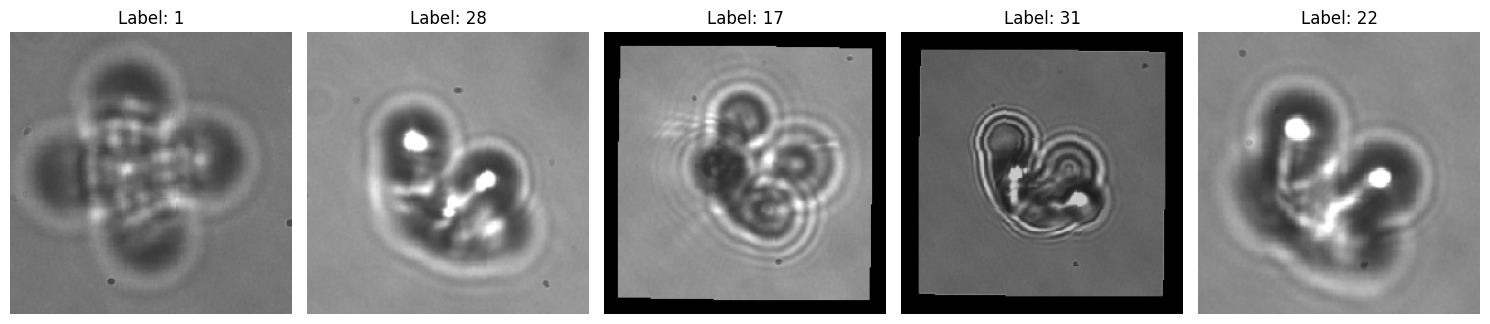

In [15]:
# Function to display augmented images
def show_augmented_images(dataloader, num_images=5):
    data_iter = iter(dataloader)      # Get an iterator for the DataLoader
    images, labels = next(data_iter)  # Get the first batch of images and labels

    # Denormalise images for visualisation
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    images = images * std + mean      # Reverse normalization

    # Plot images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        ax = axes[i]
        img = images[i].permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"Label: {labels[i]}")
    plt.tight_layout()
    plt.show()

show_augmented_images(train_loader)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [17]:
criterion = nn.CrossEntropyLoss()                         # LOSS FUNCTION

optimizer = torch.optim.AdamW(model.parameters(),         # OPTIMSER AND LEARNING RATE
                              lr=1e-4,
                              weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=4,
                                            gamma=0.1)    # SCHEDULER FOR LEARNING RATE

In [18]:
def train_model(model, train_loader, val_loader, epochs=10):

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)  # Use global criterion

            # Backward pass and optimization
            optimizer.zero_grad()  # Use global optimiser
            loss.backward()
            optimizer.step()

            # Track accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

        # Calculate training loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)  # Use global criterion

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_loss += loss.item()

        # Calculate validation loss and accuracy
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Update the learning rate based on validation loss
        scheduler.step()  # Use global scheduler

        current_lr = optimizer.param_groups[0]['lr']

        # Printing epoch results
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, "
              f"LR: {current_lr:.6f}")


    plt.figure(figsize=(14, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label="Train Loss", color='red')
    plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", color='royalblue')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss per Epoch")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label="Train Accuracy", color='limegreen')
    plt.plot(range(1, epochs + 1), val_accuracies, label="Validation Accuracy", color='darkorange')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy per Epoch")
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch [1/10], Train Loss: 3.7034, Train Accuracy: 0.0405, Validation Loss: 3.1711, Validation Accuracy: 0.2308, LR: 0.000100
Epoch [2/10], Train Loss: 2.9755, Train Accuracy: 0.1729, Validation Loss: 2.0983, Validation Accuracy: 0.5881, LR: 0.000100
Epoch [3/10], Train Loss: 2.0470, Train Accuracy: 0.4384, Validation Loss: 1.1648, Validation Accuracy: 0.8685, LR: 0.000100
Epoch [4/10], Train Loss: 1.1857, Train Accuracy: 0.7444, Validation Loss: 0.4354, Validation Accuracy: 0.9901, LR: 0.000010
Epoch [5/10], Train Loss: 0.7803, Train Accuracy: 0.8594, Validation Loss: 0.3348, Validation Accuracy: 0.9950, LR: 0.000010
Epoch [6/10], Train Loss: 0.6935, Train Accuracy: 0.8916, Validation Loss: 0.2908, Validation Accuracy: 0.9950, LR: 0.000010
Epoch [7/10], Train Loss: 0.6074, Train Accuracy: 0.9198, Validation Loss: 0.2553, Validation Accuracy: 0.9950, LR: 0.000010
Epoch [8/10], Train Loss: 0.5573, Train Accuracy: 0.9247, Validation Loss: 0.2172, Validation Accuracy: 0.9950, LR: 0.000001


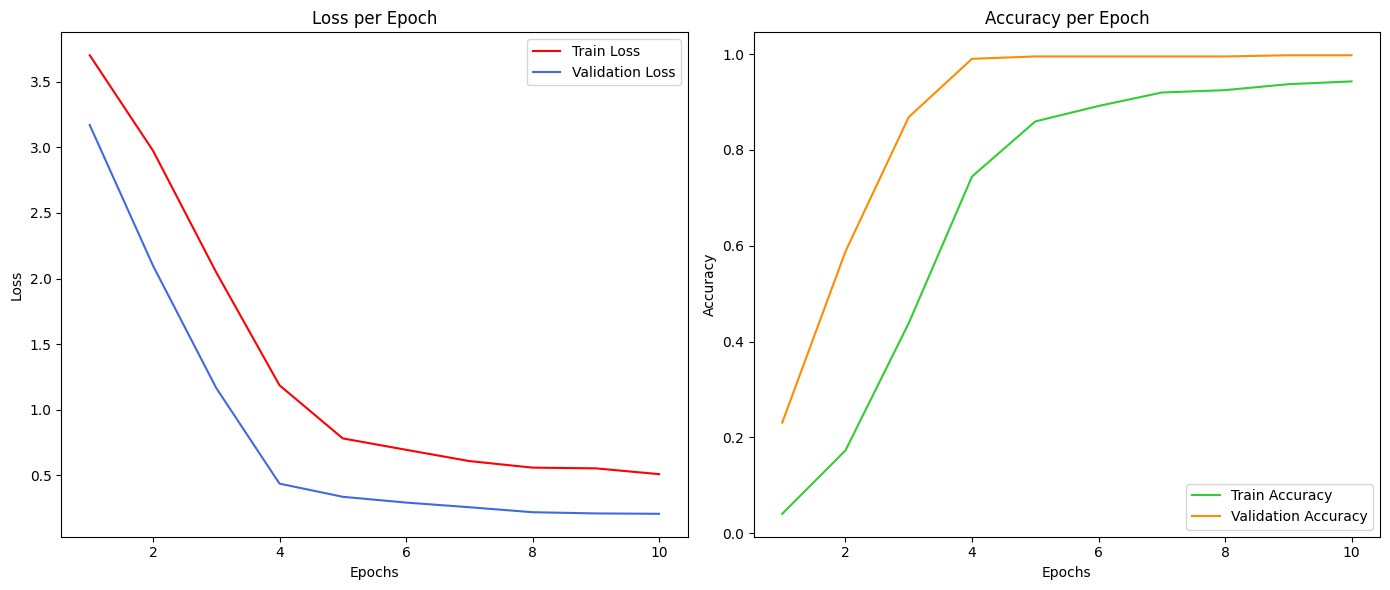

In [19]:
train_model(model, train_loader, val_loader, epochs=10)

In [20]:
# # Testing and Evaluation Function with Confusion Matrix Display
# def evaluate_model(model, test_loader):
#     model.eval()  # Set model to evaluation mode

#     y_true = []
#     y_pred = []

#     with torch.no_grad():  # Disable gradient computation
#         for images, labels in test_loader:
#             images, labels = images.to(device), labels.to(device)

#             # Forward pass
#             outputs = model(images)
#             _, predicted = torch.max(outputs, 1)  # Get predicted classes

#             # Append true and predicted labels for evaluation
#             y_true.extend(labels.cpu().numpy())
#             y_pred.extend(predicted.cpu().numpy())

#     # Calculate accuracy
#     accuracy = np.mean(np.array(y_true) == np.array(y_pred))
#     print(f"Test Accuracy: {accuracy:.4f}")

#     # Classification Report
#     report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(num_classes)], output_dict=True)
#     print("\nClassification Report:")
#     print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(num_classes)]))

#     # Calculate overall metrics (macro averaged)
#     overall_precision = report["macro avg"]["precision"]
#     overall_recall = report["macro avg"]["recall"]
#     overall_f1 = report["macro avg"]["f1-score"]

#     print(f"Overall Precision: {overall_precision:.4f}")
#     print(f"Overall Recall: {overall_recall:.4f}")
#     print(f"Overall F1-Score: {overall_f1:.4f}")

#     # Confusion Matrix
#     cm = confusion_matrix(y_true, y_pred)

#     # Plot the Confusion Matrix
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(num_classes)],
#                 yticklabels=[str(i) for i in range(num_classes)])
#     plt.xlabel("Predicted Labels")
#     plt.ylabel("True Labels")
#     plt.title("Confusion Matrix")
#     plt.show()

def evaluate_model(model, test_loader, label_encoder):
    model.eval()  # Set model to evaluation mode

    y_true = []
    y_pred = []

    with torch.no_grad():  # Disable gradient computation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get predicted classes

            # Store them
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate accuracy (numeric)
    accuracy = np.mean(np.array(y_true) == np.array(y_pred))
    print(f"Test Accuracy: {accuracy:.4f}")

    # === Decode numeric labels back to "Pitch_Roll" strings ===
    # (e.g., "20_30", "40_55", etc.)
    decoded_true = label_encoder.inverse_transform(y_true)
    decoded_pred = label_encoder.inverse_transform(y_pred)

    # Example: Show the first 5 predictions vs. ground truth
    # If you want more, increase the range or random-sample.
    print("\nSample Predictions:")
    for i in range(min(5, len(decoded_true))):
        true_pitch_str, true_roll_str = decoded_true[i].split('_')
        pred_pitch_str, pred_roll_str = decoded_pred[i].split('_')
        print(f"  Sample {i} --> True: (Pitch={true_pitch_str}, Roll={true_roll_str})"
              f" | Pred: (Pitch={pred_pitch_str}, Roll={pred_roll_str})")

    # === Classification Report (for numeric labels) ===
    print("\nClassification Report:")
    report = classification_report(
        y_true,
        y_pred,
        target_names=[str(i) for i in range(num_classes)],
        output_dict=True
    )
    print(classification_report(
        y_true,
        y_pred,
        target_names=[str(i) for i in range(num_classes)]
    ))

    # Macro-averaged metrics
    overall_precision = report["macro avg"]["precision"]
    overall_recall = report["macro avg"]["recall"]
    overall_f1 = report["macro avg"]["f1-score"]

    print(f"Overall Precision: {overall_precision:.4f}")
    print(f"Overall Recall:    {overall_recall:.4f}")
    print(f"Overall F1-Score: {overall_f1:.4f}")

    # === Confusion Matrix ===
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[str(i) for i in range(num_classes)],
                yticklabels=[str(i) for i in range(num_classes)])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()


Test Accuracy: 1.0000

Sample Predictions:
  Sample 0 --> True: (Pitch=40, Roll=40) | Pred: (Pitch=40, Roll=40)
  Sample 1 --> True: (Pitch=30, Roll=30) | Pred: (Pitch=30, Roll=30)
  Sample 2 --> True: (Pitch=50, Roll=50) | Pred: (Pitch=50, Roll=50)
  Sample 3 --> True: (Pitch=30, Roll=60) | Pred: (Pitch=30, Roll=60)
  Sample 4 --> True: (Pitch=40, Roll=60) | Pred: (Pitch=40, Roll=60)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00        12
           7       1.00      1.00      1.00        12
           8       1.00      1.00      1.00        11
           9       1.00      1.00      1.00    

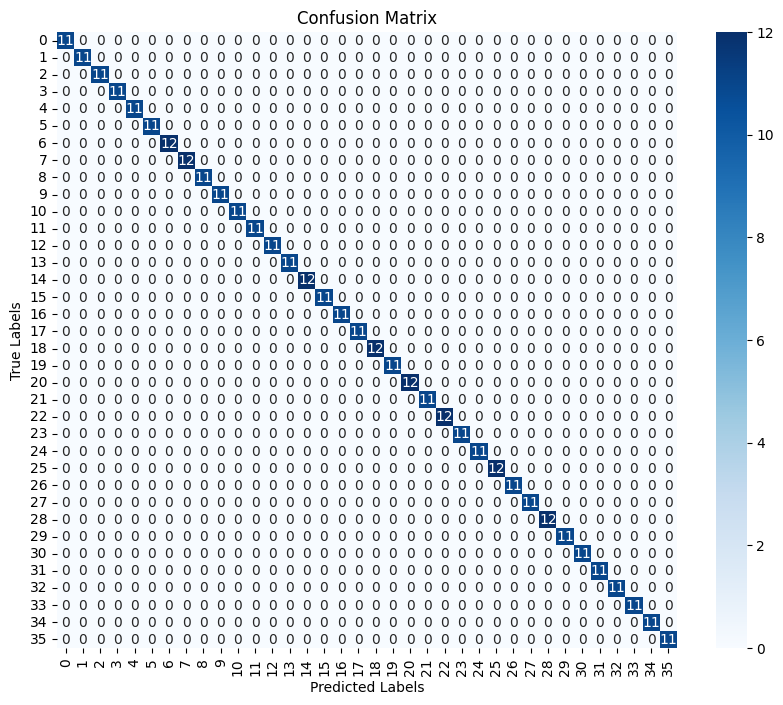

In [21]:
evaluate_model(model, test_loader, label_encoder)

In [22]:
torch.save(model.state_dict(), "pose_classification_resnet_gurmeher.pth")

In [23]:
from google.colab import files
files.download("pose_classification_resnet_gurmeher.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
import pickle

# Save the label encoder (the one that was fit on labels['Pose_Class'])
with open("pose_label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

In [25]:
from google.colab import files
files.download("pose_label_encoder.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>